In [1]:
# Libraries
#nbconvert:hide_input

import pandas as pd
from matplotlib import pyplot as plt

import plotly.express as px

import plotly.graph_objects as go

import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2})

In [2]:
#nbconvert:hide_input
df = pd.read_csv("../../data/processed/ail_price.csv", parse_dates=["date"], index_col="date")
df = df.sort_values(by="date")

features = pd.read_csv("../../data/processed/complete_data/features.csv", parse_dates=["date"], index_col="date")
target = pd.read_csv("../../data/processed/complete_data/target.csv", parse_dates=["date"], index_col="date")
results = pd.read_csv("../../results/rolling_predictions_rmse.csv")

features = features.sort_values(by="date")
price = pd.DataFrame(df['price'])
feature_df = pd.merge(features, target, left_index=True, right_index=True)

In [3]:
results = pd.read_csv("../../results/rolling_predictions_rmse.csv")

results = results.reset_index(drop=True)
results

,1_step_rmse,2_step_rmse,3_step_rmse,4_step_rmse,5_step_rmse,6_step_rmse,7_step_rmse,8_step_rmse,9_step_rmse,10_step_rmse,11_step_rmse,12_step_rmse,model_start_date,prediction_end_date,avg_fold_rmse
0,29.011604,34.938361,37.208972,37.100096,47.037687,84.249626,109.361897,140.602814,163.574593,161.719152,165.172238,166.323702,2022-12-01,2023-02-02,88.89


In [4]:
import pandas as pd
from datetime import datetime

# Convert string to datetime
results['model_start_date'] = pd.to_datetime(results['model_start_date'])
results['prediction_end_date'] = pd.to_datetime(results['prediction_end_date'])

# Get day from date
start_day = results['model_start_date'].dt.strftime('%b %d %Y')[0]
end_day = results['prediction_end_date'].dt.strftime('%b %d %Y')[0]

print(f"The training data is from {start_day} to Jan 31 2023.")
print(f"The test data is from Feb 01 2023 to {end_day}.\n")
# Select desired columns
selected_columns = results[["1_step_rmse", "2_step_rmse", "3_step_rmse", "4_step_rmse", "5_step_rmse",
                       "6_step_rmse", "7_step_rmse", "8_step_rmse", "9_step_rmse", "10_step_rmse",
                       "11_step_rmse", "12_step_rmse"]]

selected_columns = selected_columns.reset_index(drop=True)

selected_columns = selected_columns[["1_step_rmse", "2_step_rmse", "3_step_rmse", "4_step_rmse", "5_step_rmse",
                       "6_step_rmse", "7_step_rmse", "8_step_rmse", "9_step_rmse", "10_step_rmse",
                       "11_step_rmse", "12_step_rmse"]]

selected_columns

The training data is from Dec 01 2022 to Jan 31 2023.
The test data is from Feb 01 2023 to Feb 02 2023.



,1_step_rmse,2_step_rmse,3_step_rmse,4_step_rmse,5_step_rmse,6_step_rmse,7_step_rmse,8_step_rmse,9_step_rmse,10_step_rmse,11_step_rmse,12_step_rmse
0,29.011604,34.938361,37.208972,37.100096,47.037687,84.249626,109.361897,140.602814,163.574593,161.719152,165.172238,166.323702


## Final Report : Power Price Prediction

### Contributors

- Arjun Radhakrishnan
- Sneha Sunil
- Gaoxiang Wang
- Mehdi Naji

### Executive Summary 

 Numerous Alberta-based organizations rely heavily on energy to fuel their business operations and are in search of an effective forecasting tool that offers accurate and interpretable predictions. Our business solution precisely addresses this need by offering an interpretable and explainable data science product deployed on the cloud, specifically designed for power price prediction in the Alberta Energy Market. Our solution equips organizations with the ability to make knowledgeable decisions about their energy purchases by forecasting hourly energy prices for the next 12 hours, supplemented with confidence intervals. The solution will also address the lack of interpretability and explainability of predictions in the current system[[1]](https://aeso-portal.powerappsportals.com/data-portal-dashboard/) which only forecasts for the next 6 hours. Our real-time prediction pipeline, deployed on Databricks, is complemented by an intuitive Tableau dashboard. This dashboard displays pertinent visualizations, enabling stakeholders to monitor real-time hourly predictions along with their associated margins of error. This approach ensures that organizations are well-informed, facilitating strategic decision-making to optimize their energy utilization.

### Introduction

Over the past few decades, the electricity markets have undergone a significant transformation, shifting from regulated systems to competitive and deregulated environments. In the province of Alberta, the electricity market operates within a framework where prices are determined by the interplay of supply and demand dynamics in a competitive marketplace. Unlike a regulated market, the government does not directly intervene in setting the prices. Instead, prices are influenced by various participants in the market, including power generators, transmission companies, and retailers. This market structure allows for increased flexibility but also exposes prices to the forces of supply and demand. Consequently, the deregulated nature of the electricity market in Alberta plays a crucial role in the volatility of power prices.
To illustrate the extent of this volatility, an interactive plot below vividly showcases the substantial variations in price specifically for March 2023. As you explore the plot, you will witness the dramatic ups and downs, serving as a testament to the dynamic nature of the pool price during that particular period. This serves as a striking reminder of the inherent complexity in the data science problem that needs to be addressed.

In [5]:
fig = px.line(df, y="price")
fig.update_layout(
    title={
        "text": "Energy Pool Price Variation Over Time",
        "font": {"size": 18, "family": "Arial", "color": "black"},
        "y": 0.97,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    xaxis_title={
        "text": "Date",
        "font": {"size": 18, "family": "Arial", "color": "black"},
    },
    yaxis_title={
        "text": "Price",
        "font": {"size": 18, "family": "Arial", "color": "black"},
    },
    xaxis_range=["2023-03-01", "2023-03-31"],
    height=500,
)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list(
            [
                dict(count=1, label="Daily", step="day", stepmode="backward"),  
                dict(count=1, label="1-Month", step="month", stepmode="backward"),
                dict(count=6, label="6-Month", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1-Year", step="year", stepmode="backward"),
                dict(step="all")
            ]
        )
    ),
)
fig.show()


Since 2016, electricity prices in Alberta have consistently risen, accompanied by increased volatility. This volatility can be attributed to multiple factors, including the following key drivers. Firstly, the growing demand for electricity in Alberta has been fueled by population growth and expanding industries. This surge in demand has strained the power infrastructure, resulting in tighter supply-demand dynamics and driving prices higher. Moreover, the integration of intermittent renewable energy sources has introduced price volatility to the electricity market in Alberta. Fluctuations in the availability of renewable energy directly impact the overall supply and, consequently, affect prices. Additionally, fluctuations in fuel costs, particularly natural gas, significantly influence the overall cost of electricity generation in Alberta. Variations in fuel prices directly impact the cost of producing electricity, thereby impacting the prices paid by consumers. 

In [6]:
price = pd.DataFrame(df['price'])
ppx = pd.DataFrame()
ppx['std'] = price.groupby(price.index.year).std()
ppx['mean'] = price.groupby(price.index.year).mean()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=ppx.index,
    y=ppx['mean'],
    error_y=dict(
        type='data',
        array=ppx['std'],
        visible=True
    ),
    marker=dict(color='red'),
    opacity=0.7
))

fig.update_layout(
    title='Mean and Standard Deviation of Power Pool Price in Alberta',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Power Pool Price (CAD)'),
    showlegend=False,
    width=1000,  # Set the desired width of the image
    height=600  # Set the desired height of the image
)

fig.show()


Energy-intensive industries in Alberta heavily depend on accurate price predictions to plan for future energy costs, optimize their operations and mitigate the effects of price fluctuations. In light of the growing uncertainty caused by escalating price volatility, the significance of accurate electricity price predictions cannot be emphasized enough. These predictions play a pivotal role in enabling stakeholders, including energy buyers, to navigate the market successfully by efficiently strategizing their operations. Currently, these organizations depend on energy forecasting tool published by AESO - Alberta Electric System Operator to determine their energy costs in advance as they purchase large quantities of energy based on demand for their business operations. AESO is an independent system operator in Alberta responsible for operating the electrical grid, facilitating the competitive electricity market, and managing the entire power distribution system for the province. The power pool price for every hour is finalized by AESO based on supply and demand. However, the current energy forecasts published by AESO only provide a short-term coverage of 6 hours into the future, which is volatile and lacks interpretation or model visibility. Moreover, they do not quantify the uncertainty associated with the predictions. 

To reduce their expenses, companies could plan and potentially explore alternative energy options if they have access to accurate forecasts which covers a longer window and is also interpretable and explainable. To address the challenges faced by organizations in Alberta, our cutting-edge product offers a comprehensive solution that empowers them to effectively analyze costs, optimize energy purchases, and ultimately maximize their profits. The scientific objectives of our product are 

- Forecasting energy prices for the next 12 hours 
- Interpretability and explain ability of predictions 
- Scalable and Realtime prediction pipeline
- Reactive Tableau Dashboard for visualizing the real-time results

The real time prediction pipeline is deployed on databricks and is intergrated with the dashboard which will showcase real-time market price predictions and data visualizations  for interpretibility of predictions that are interactive and informative for the audience.

### Data Science Techniques


Our project utilized two primary data sources: 

**Open-source Tableau Data**: We had access to historical hourly time series data published by AESO in Tableau. The dataset encompasses 110 distinct features and consists of approximately 72,000 observations.

**Open-source API Data** :  AESO provides a public API service that grants us access to real-time and historical data for specific selective features.

Our initial dataset consisted of approximately 110 features, covering various aspects such as power generation/supply by fuel type, energy load distribution across regions, import and export data, and system marginal price data. The primary target we focused on forecasting was the power pool price (CAD). This price represents the balanced average power price per hour for the Alberta province, determined by AESO based on supply and demand. It is capped between 0 and 1000 to ensure that the Alberta electricity market is stable and fair. Our feature set predominantly comprises numerical data, with one exception of an ordinal feature which was engineered by us.

In [15]:
price['day'] = price.index.day_name()
price['hour'] = price.index.hour

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_avgday = {}
fig = go.Figure()

for day in days_of_week:
    df_avgday[day] = price[price['day'] == day].groupby('hour')['price'].mean().reset_index()
    trace = go.Scatter(
        x=df_avgday[day]['hour'],
        y=df_avgday[day]['price'],
        mode='lines',
        name=day
    )
    fig.add_trace(trace)

fig.update_layout(
    title='Average Price by Hour for Each Day of the Week',
    xaxis=dict(title='Hour'),
    yaxis=dict(title='Average Price')
)

fig.show()


Examining the above plot, a consistent trend emerges: energy prices tend to be higher during peak hours on weekdays, which correspond to the typical working hours spanning from approximately 8 am to 8 pm. Furthermore, the daily plots unveil a distinct seasonal pattern in energy prices. Weekdays exhibit higher prices during working hours, reflecting the increased demand associated with business operations, while prices decrease during off-working hours. On weekends, prices follow a different pattern, with higher prices observed during the evenings. These observations are supported by the autocorrelation function plots, which clearly demonstrate daily seasonality in energy prices. Interestingly, the plot also indicate that, on average, Tuesdays have the highest prices compared to other weekdays. To capture the combined effects of the day of the week, the hour of the day, and the distinction between peak and off-peak hours, an ordinal feature called 'weekly_profile' was created which allows for a comprehensive representation of the interplay between time-related variables and energy pricing dynamics.

In [8]:
import plotly.graph_objects as go

# Calculate the average power price for each hour of the day
average_price = df.groupby(df.index.hour)['price'].mean()

# Create the plotly figure
fig = go.Figure()

# Add a scatter trace for the average power price
fig.add_trace(go.Scatter(
    x=average_price.index,
    y=average_price,
    mode='markers',
    marker=dict(symbol='circle', size=8),
    name='Average Power Price'
))

# Add a line trace for the average power price
fig.add_trace(go.Scatter(
    x=average_price.index,
    y=average_price,
    mode='lines',
    line=dict(color='blue', width=4),  # Set line width to 2
    name='Average Power Price Line'
))

# Update layout
fig.update_layout(
    title={
        'text': 'Average Power Price by Hour of the Day',
        'x': 0.5,  # Center the title
        'y': 0.9,  # Increase the y position for title size
        'xanchor': 'center',  # Center the title horizontally
        'yanchor': 'top',  # Anchor the title from the top
        'font': dict(size=24)  # Increase the title font size
    },
    xaxis=dict(
        title='Hour of the Day',
        tickmode='array',
        tickvals=list(range(24)),
        ticktext=[str(i) for i in range(24)],
        tickfont=dict(size=14, family='Arial, bold'),  # Bold and increased size for x-axis tick labels
    ),
    yaxis=dict(
        title='Average Power Price(CAD)',
        tickfont=dict(size=14, family='Arial, bold'),  # Bold and increased size for y-axis tick labels
    ),
    showlegend=False,  # Remove the legends,
    width=1000  # Decrease the width of the plot
)

# Show the plot
fig.show()


In [9]:
import plotly.graph_objects as go

# Filter the data for the year 2021 and beyond
data_gt_2021 = df[df.index.year >= 2021]

# Calculate the average power price for each day of the week
average_price = data_gt_2021.groupby(data_gt_2021.index.dayofweek)['price'].mean()

# Define the days of the week
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Create the plotly figure
fig = go.Figure()

# Add a scatter trace for the average power price
fig.add_trace(go.Scatter(
    x=days_of_week,
    y=average_price,
    mode='markers+lines',
    marker=dict(symbol='circle', size=8, color='green'),  # Set marker color to green
    line=dict(color='green', width=5),  # Set line color to green and increase line width
    name='Average Power Price'
))

# Update layout
fig.update_layout(
    xaxis=dict(
        title='Day of the Week',
        tickmode='array',
        tickvals=list(range(7)),
        ticktext=days_of_week,
        tickfont=dict(size=14, family='Arial, bold')  # Bold and increased size for x-axis tick labels
    ),
    yaxis=dict(
        title='Average Power Price',
        tickfont=dict(size=14, family='Arial, bold')  # Bold and increased size for y-axis tick labels
    ),
    showlegend=False,
    title={
        'text': 'Average Power Price by Day of the Week',
        'x': 0.5,  # Center the title
        'y': 0.9,  # Increase the y position for title size
        'xanchor': 'center',  # Center the title horizontally
        'yanchor': 'top',  # Anchor the title from the top
        'font': dict(size=24)  # Increase the title font size
    },
    width=1000  # Decrease the width of the plot
)

# Show the plot
fig.show()


This is an autocorrelation function plot with 50 lags for the pool price. We can clearly see a daily seasonality in this plot (for every 24 hours).
Note : ACF plot depicts the correlation between the price and its lagged values

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm

# Calculate ACF
acf_values, confint_acf = sm.tsa.stattools.acf(price['price'], nlags=50, alpha=0.05)

# Create subplots
fig = make_subplots(rows=1, cols=1)

# Add ACF subplot
fig.add_trace(
    go.Bar(
        x=list(range(len(acf_values))),
        y=acf_values,
        marker=dict(color='#ff7f0e')
    ),
    row=1, col=1
)

# Update layout
fig.update_layout(
    title={
        'text': 'Correlogram of prices (Hourly)',
        'x': 0.5,  # Center the title
        'xanchor': 'center',  # Center the title,
        'font': dict(size=24)  # Increase the title font size
    },
    xaxis=dict(title='Lags (Hourly)'),
    yaxis1=dict(title='ACF'),
    showlegend=False,
    width=1000  # Decrease the width of the plot
)

# Show the plot
fig.show()



For the modeling purpose, we partitioned our data into two subsets: training and testing. The training data encompasses the period from January 2021 to January 2023, while the test set refers to the data from February - May 2023. Given the absence of real-time data for all features through the API, we leveraged historical data to simulate a real-time prediction system. The simulated system provides real-time forecasts starting from February 1, 2023. When real-time data becomes accessible for the clients, they can seamlessly swap the data sources, thereby enabling real-time data flow into the model which will make real-time predictions.

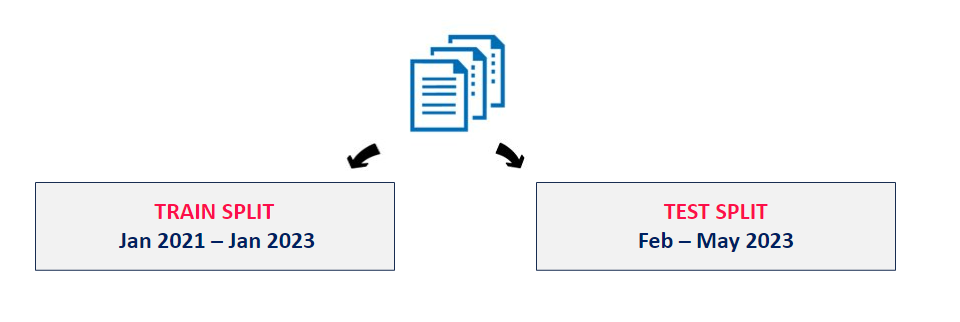

#### Data preprocessing

In our pursuit to accurately predict future prices based on historical values of influential factors like supply and demand, we transformed the time-series data of all the features into a tabular format. This transformation process involved creating lagged versions of both the target variable and the relevant features. Each lagged version corresponds to a specific hour, with the price for that hour being used as the target variable. By incorporating these lagged variables, we aim to leverage the historical values of the features and the target itself to enhance our predictive capabilities.

In [11]:
import plotly.graph_objects as go

# Create a violin plot of price with increased size
fig = go.Figure(data=go.Violin(x=df['price'], box_visible=False, meanline_visible=True,
                              fillcolor='#32CD32', line_color='black', width=0.8))

# Update layout
fig.update_layout(
    title={
        'text': 'Distribution of Price',
        'x': 0.5,  # Center the title
        'xanchor': 'center'  # Center the title
    },
    xaxis=dict(title='Price', range=[0, 200]),
    yaxis=dict(title=None, showticklabels=False),
    showlegend=False,
    width=800,  # Set the width of the plot
    height=500  # Set the height of the plot
)

# Show the plot
fig.show()




To address the inherent challenges of our target variable - price like extreme volatility, we attempted several transformation techniques:

`Log Transformation`: Given the skewed nature of the price data, a logarithmic transformation was used with an intent to normalize its distribution. This transformation could potentially make patterns in the data more interpretable and better meet the assumptions of downstream modeling techniques.

`Standard Scaler`: The standard scaler transformation was applied to standardize the price values. This technique could help minimize the effect of outliers and varying scales across different features by scaling the values to have a mean of 0 and a standard deviation of 1.

`Discretization`: The discretization transformation was used as it often complements tree-based models such as LightGBM, improving their performance by turning continuous features into several bins, each representing a range of price values.

Despite these efforts, none of these transformations led to significant improvements in our model's predictive performance. Consequently, we decided to proceed with the original scale of the price variable. This approach might also simplify the interpretation and communication of the model results, as the predictions will be in the same scale as the original data.

#### Feature Selection and Engineering

In the process of feature selection out of 110 features, our primary strategy involved examining the correlations between various features and the price in the preliminary round. Considering the importance of interpretability in our model, we also conducted comprehensive market research and engineered several key features showing significant correlation with the price. One such feature is the gas reserve margin reserve, a buffer/reserve of gas, readily available to generate electricty to meet sudden load demands and peak usage hours. As evidenced in our data visualizations, a dwindling gas reserve tends to correspond with an increase in price. In case of gas supply mix which is the proportion of energy generation using gas by the total energy generation, when the supply is mostly using gas, the price increases as gas is costly compared to the rest of the sources. 

For more information about the key engineered features, please check out the [glossary](https://github.com/slalom-ubc-mds/Power-Price-Prediction/blob/main/notebooks/final_report/glossary.ipynb)


In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Filter the data within the desired date range
final_2022_df = feature_df[(feature_df.index >= '2022-11-15') & (feature_df.index <= '2022-12-19')]
# Create subplot figure with 2 rows and 1 column
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Add first trace for price subplot
fig.add_trace(go.Scatter(x=final_2022_df.index, y=final_2022_df['price'], name="Pool Price", hovertemplate='Date: %{x}<br>Price: %{y}<br>Day of week: %{x|%A}', line=dict(width=4) ), row=1, col=1)

# Add second trace for temperature subplot
fig.add_trace(go.Scatter(x=final_2022_df.index, y=final_2022_df['gas_reserve_margin'], name="Gas Reserve Margin", hovertemplate='Date: %{x}<br>Price: %{y}<br>Day of week: %{x|%A}', line=dict(width=4)), row=2, col=1)

fig.add_trace(go.Scatter(x=final_2022_df.index, y=final_2022_df['gas_supply_mix'], name="Gas Suply Mix", hovertemplate='Date: %{x}<br>Price: %{y}<br>Day of week: %{x|%A}', line=dict(width=4)), row=3, col=1)

fig.update_layout(
    title={
        "text": "Pool price Over Time",
        "font": {"size": 18, "family": "Arial", "color": "black"},
        "y": 0.97,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    xaxis_title={
        "font": {"size": 18, "family": "Arial", "color": "black"}
    },
    height=800,
    yaxis1={
        "title": "Price",
        "titlefont": {"size": 18, "family": "Arial", "color": "black"},
        "tickvals": [0, 250, 500, 750, 1000], # Set tick values for price yaxis,
        "side": "left", # Set yaxis to left side
    },
    yaxis2={
        "title": "Gas Reserve Margin",
        "titlefont": {"size": 18, "family": "Arial", "color": "black"},
        "side": "left", # Set yaxis to right side,
        "showgrid": True, # Show grid lines,

    },
    yaxis3={
        "title": "Gas Suply Mix",
        "titlefont": {"size": 18, "family": "Arial", "color": "black"},
        "side": "left", # Set yaxis to right side,
        "showgrid": True, # Show grid lines,
        "zeroline": True, # Add dark line at y=0 on x-axis
        "zerolinecolor": "black", # Set the color of the zeroline to black
        "zerolinewidth": 2, # Set the width of the zeroline to 2

    },
    shapes=[
        {
            "type": "line",
            "x0": 0,
            "x1": 1,
            "xref": "paper",
            "y0": 68.839691,
            "y1": 68.839691,
            "yref": "y3",
            "line": {"color": "black", "width": 2},
        },       
        {
            "type": "line",
            "x0": 0,
            "x1": 1,
            "xref": "paper",
            "y0": 14.095177,
            "y1": 14.095177,
            "yref": "y2",
            "line": {"color": "black", "width": 2},
        },       
        # {
        #     "type": "line",
        #     "x0": 0,
        #     "x1": 1,
        #     "xref": "paper",
        #     "y0": 159.876516,
        #     "y1": 159.876516,
        #     "yref": "y1",
        #     "line": {"color": "black", "width": 2},
        # }
    ],
    xaxis={
        "showgrid": True, # Show grid lines,
    },
)

# Add slider
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1,
        nticks=10,
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="Daily", step="day", stepmode="backward"),  
                    dict(count=1, label="1-Month", step="month", stepmode="backward"),
                    dict(count=6, label="6-Month", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1-Year", step="year", stepmode="backward"),
                    dict(step="all")
                ]
            )
        ),
        rangeslider=dict(visible=True, thickness=0.01, borderwidth=0)
    )
)

fig.show()


We further refined our feature set by leveraging the coefficients from an Elastic Net CV model, and the feature importances deduced from training a Random Forest Regressor model. 

Pursuing a second strategy, we investigated the correlation between lagged features and future prices projected for periods ranging from 1 to 12 hours. We identified features exhibiting correlations of absolute value greater than 0.3 and incorporated them into our feature set. Interestingly, both strategies resulted in almost identical sets of features.

In [13]:

feature_df = feature_df[(feature_df.index >= '2022-01-01')]
corr_df = feature_df[['gas_supply_mix', 'wind_supply_mix', 'wind_reserve_margin', 'gas_reserve_margin', 'gas_tng', 'load_on_gas_reserve', 'price']]

In [14]:
import pandas as pd
import plotly.express as px

# Calculate the correlation matrix using Spearman method
corr = corr_df.corr(method='spearman')

# Select the correlation with the 'price' feature
corr_with_price = corr['price']

# Transpose the correlation matrix
corr_transposed = pd.DataFrame(corr_with_price).T

# Create the transposed correlation matrix plot using Plotly Express
fig = px.imshow(corr_transposed,
                color_continuous_scale='viridis',
                title="Correlation Matrix for Top Features and Price")

fig.update_layout(
    width=1000,
    height=500,
)

fig.show()


It's worth noting that we found some features to be inter-correlated, suggesting that Principal Component Analysis (PCA) could potentially streamline our current feature set by reducing dimensionality. However, PCA tends to complicate feature interpretability, presenting a challenge for end-users. While PCA offers benefits such as reducing computational burden and enhancing model performance, these gains must be weighed against the increased complexity and reduced interpretability. Since interpretibility was important for the users, we elected not to employ PCA in our model development.


#### Modelling Strategy

Since the price is extremely volatile, tackling our first scientific objective which is forecasting energy for the next 12 hours seemed like a complex task. Hence, we needed models that is apt for time series forecasting which is able to pick up the temporal patterns. Computational efficiency for initial training and repeated updates was also needed. As a baseline model for our problem, we chose the **SARIMA**(Seasonal AutoRegressive Integrated Moving Average) model which is a classical model as it fulfilled the above requirements and also supported probabilistic forecasting. Additionally, one of the advantages of using the SARIMA model was the ability to generate confidence intervals for our forecasts. Using SARIMA, we performed univariate forecasting, predicting the future values of the price based on the past values of the price alone. Our evaluation of the model resulted in an average error of 83.85 CAD, with a standard deviation of approximately 73.11 CAD.

However, recognizing that our problem involved multi-step forecasting, we decided to transition to more sophisticated machine learning models to improve the accuracy of our forecasts. In this approach, we incorporated the key engineered features we had developed in addition to using past price values alone.

In terms of prediction strategy for the multistep forecasting problem, we chose the **direct strategy** over the recursive strategy. In recursive strategy, we iteratively forecast the future time step values using the predicted values. This means that the model is first trained with historical data uptil the cut off point. The cut off hour refers to the specific point in time up to which you use the data to train your model. Once the model is trained, an initial prediction is made for the next time step after the cut off point which is then again used to train the model and used as an input for the next prediction. We did not use this strategy for our modelling pipeline because the prices are extremely volatile and the recursively predicting price would propagate errors making the pipeline unstable and predictions unreliable. 

For our forecasting horizon of 12 steps, we implemented the direct strategy in our modeling approach. This involved training 12 individual models, each responsible for predicting the power price for a specific timestep within the forecasting horizon (1, 2, 3... 12). With the direct strategy, all 12 models were trained using the same historical data. Each model was designed to directly forecast the target value for its respective timestep. For example, Model 1 would consistently predict the power price for the next timestep, while Model 12 would forecast the price for 12 timesteps into the future. By adopting this approach, we avoided the accumulation of errors that can occur in the recursive strategy. The direct strategy ensured that each model relied solely on real pool prices for its predictions, rather than recursively utilizing previously predicted values. This effectively controlled error propagation and enhanced the accuracy of our forecasts. Additionally, when a new data point became available, we updated the cut-off time by 1 hour and retrained all 12 models using the most recent data. This allowed us to continuously incorporate real-time data and ensure reliable future predictions. One critical factor we considered in selecting our final model was its ability to update its parameters efficiently with minimal computation time. This consideration was crucial for handling the frequent updates required in our real-time forecasting scenario, enabling us to maintain a reliable and responsive modeling pipeline.

To build our base pipeline, we leveraged the sktime package, a widely-used package that supports time series forecasting and enables the application of machine learning models on time series data. One drawback of our approach was that it involved incorporating 12 models into the pipeline, which increased its size and computational intensity. Furthermore, whenever a new data point became available, we needed to refit the data to all 12 models, which could be time-consuming and impact real-time responsiveness. To address the challenge of refit time using sktime package, we implemented custom code that significantly reduced the refit times from approximately 4.5 minutes to less than 0.5 seconds. This optimization was a significant achievement for us, allowing us to overcome the computational burden and enhance the efficiency of our pipeline. Once our pipeline was set up, we focused on researching models that were well-suited to our forecasting problem. Our research aimed to identify models that were scalable, capable of providing accurate predictions, and able to handle multicollinearity within the data. We sought models that could effectively capture complex relationships and patterns, thereby improving the quality of our forecasts.

#### Experimented models

 Our initial choice for modeling was Elastic Net CV, a linear regression model that effectively handles multicollinearity and supports feature selection. Given our emphasis on interpretability, a linear model was a suitable option as it offers straightforward interpretation of coefficients and relationships between variables. In addition to Elastic Net CV, we explored the Random Forest Regressor model. This ensemble model constructs multiple decision trees during training and outputs the mean predictions from the individual trees. Random Forest Regressor helps mitigate overfitting and can capture complex nonlinear relationships present in the data. We also considered XGBoost, a powerful gradient boosting algorithm that excels in efficiency and has a strong track record in various domains. XGBoost met our requirements in terms of accuracy, handling large datasets, and managing multicollinearity. Finally, we integrated the LightGBM model into our pipeline. LightGBM satisfied all our requirements, including scalability and efficient model fitting. It particularly excelled when loaded on a GPU, enabling faster training times for large datasets. Notably, LightGBM supports warm initialization, enabling rapid model refitting on new data, which was essential for our real-time forecasting scenario.

#### Cross Validation 

After selecting our set of models, we performed cross-validation to assess their performance. Our training data spanned from January 1st, 2021, to January 31st, 2023. To capture any seasonality in price variation over time, we initially trained our models using two years' worth of data. For cross-validation, we utilized the entire month of January 2023, creating 63 folds to validate our models. Since our data is time series data, preserving the temporal order of the data in each fold was crucial. The first fold consisted of an initial training window of two years and a validation set spanning 12 hours of data. We made predictions for these 12 hours and compared them with the actual prices in the validation set to calculate the errors. We then expanded the training window by including the 12 hours of data from the validation set and proceeded to predict the next 12 hours. This process was repeated for a total of 63 folds.

To assess model performance, we selected the Root Mean Square Error (RMSE) as our evaluation metric. RMSE was chosen because it aligns with our project's focus on interpretability and is easily understandable. The RMSE metric provides an error value in the same scale as the actual values, measured in CAD/MW. This allows for straightforward interpretation and comparison of the performance of different models.

#### Cross Validation Results 

In the comparison of various machine learning models for forecasting purposes, the Light GBM model stood out with an RMSE of 89.72 and a Std Dev of 71.60 (Cad/MW). The other models demonstrated varying performance levels. XGBoost, with a slightly higher RMSE of 89.12 and almost identical Std Dev of 77.67, performed nearly as well as Light GBM. The Random Forest Regressor offered decent performance with an RMSE of 144.41 and Std Dev of 72.57, while the ElasticNetCV had an RMSE of 82.85 and the lowest Std Dev of 74.04. The ARIMA model being the baseline had an RMSE of 83.85 and a Std Dev of 73.117.

Light GBM stood out as the best model for our forecasting pipeline, considering our specific requirements. It offered several advantages over the other models.

Firstly, Light GBM exhibited remarkable computational efficiency and faster fit times compared to the alternative models. This made it highly suitable for power price prediction where quick model updates were essential once actual prices are published by AESO. The ability to update the model rapidly ensured that our predictions remained up-to-date and responsive to the latest data. Additionally, Light GBM uniquely captured spikes in prices, while the other models struggled to capture such sudden changes, resulting in flatter predictions even though they had lower RMSEs. Light GBM also supported quantile regression, enabling us to generate confidence intervals for our predictions. This feature was crucial for quantifying uncertainty and providing a range within which future price values were expected to fall. By incorporating quantile regression, Light GBM facilitated better decision-making and risk assessment by quantifying the level of confidence associated with our forecasts. Another notable feature of Light GBM was its warm state capability. This feature allowed the model to retain and update its previously learned information when new data became available. By leveraging warm state, Light GBM reduced computational overhead and swiftly adapted to changing patterns or trends in the data. 

Considering all these advantages, Light GBM emerged as the optimal choice for our forecasting pipeline. Its computational efficiency, spike detection, support for quantile regression, and warm state capability collectively made it the most suitable model for our requirements, enabling accurate, reliable, and timely forecasts for our real-time decision-making processes.


#### Interpretibility of predictions 

To achieve our second scientific objective of obtaining feature importances and interpreting the predictions of our model, we relied on the **SHAP (SHapley Additive exPlanations)** framework. SHAP enables us to explain and interpret the individual predictions made by our model. For each prediction the model make, we can easily obtain the SHAP values of each of the features for this prediction, which will quantify the impact and contribution of each feature for the prediction. This local interpretability helps us understand the factors driving individual predictions. To establish a reference point for comparison, we used a base value, which represents the average value of predictions made by the model. This base value acts as a benchmark, allowing us to evaluate the impact of each feature in relation to the model's expected output. The SHAP values can be positive or negative, indicating the direction and magnitude of influence. Positive SHAP values indicate that a feature positively influenced the prediction, pushing the prediction value higher than the base score. Conversely, negative SHAP values indicate a negative influence on the prediction.In our dashboard or visualizations, we explicitly showcased the percentage increase or decrease contributed by each feature compared to the base score. This provides a clear understanding of how much each feature contributes to the current prediction, allowing for intuitive interpretation and explanation of the model's behavior.

#### Quantifying Uncertainity

To quantify the uncertainty of our predictions, we utilized quantile regression to obtain the 95% confidence intervals. Since our final model, LightGBM, supports quantile regression, we trained two separate LightGBM models with the objective as quantile regression. The first LightGBM model was trained to predict the upper limit of the confidence interval. To achieve this, we configured the desired quantile to be 0.975, representing the 97.5th percentile of the distribution. The second LightGBM model was trained to predict the lower limit of the interval, with the desired quantile set to 0.025, representing the 2.5th percentile. After training the models, we utilized the predict() method to obtain the predicted quantiles for each prediction. These predicted quantiles represented the upper and lower limits of the 95% confidence interval. This provided a measure of uncertainty and allowed us to communicate the level of confidence associated with our forecasts.

#### Test Results 

Coming to the most awaited test results, our modelling pipeline outperformed AESO's model across all timesteps for the time range of May 25 - May 31st as shown in the table. Our prediction pipeline demonstrates superiority not just in short-term 1-step and 2-step forecasts but continues to maintain lower RMSE values across multiple steps, right up to 12-step forecasts. Importantly, our model also has the capacity to make forecasts beyond the 6-step limit of the AESO model. This extended range and increased accuracy throughout the forecasting horizon underscore the enhanced performance and superior predictive power of our model compared to the AESO model.

It is noteworthy that the RMSE of our model consistently stays in a relatively lower range, even at higher step predictions. This implies that our model's accuracy doesn't degrade significantly with the extension of the forecast horizon, which is a highly desirable feature in multi-step forecasting models. Overall, this analysis establishes the robustness and efficacy of our prediction pipeline in multi-step forecasting.

We can see below the stepwise errors for the time range of May 25 - May 31st.

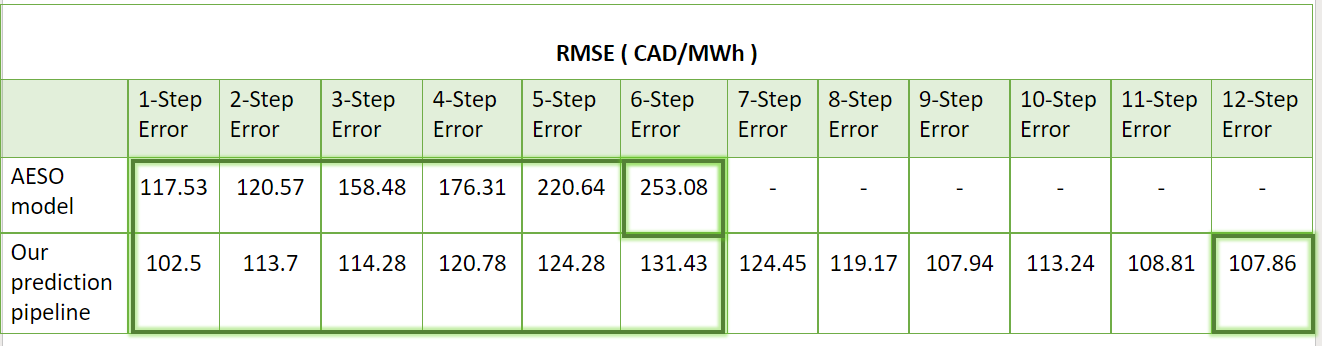


For the entire test set starting from Feb 2023 - May 2023, the results are given below - 
Light GBM generalized well and performed the best with an RMSE of 133.972 and std deviation of 114.48.

#### Deployment Architecture 

Inorder to make our machine learning pipeline scalable, we have deployed our product in Databricks. Our architecture involves two main jobs running within Databricks. We also have two storage units - one for storing the predictions for dashboard and the second one for archiving all the predictions made by the model. The first job serves as our initial training pipeline, responsible for training the model using the training dataset and subsequently saving the trained model. We also store the model predictions, upper and lower limits, as well as the prediction explanations. These details are stored in both the real-time predictions table and the archive table.

To ensure the continuous availability of updated insights, our tableau dashboard regularly retrieves new data from the real-time predictions table and refreshes its charts accordingly. This mechanism enables us to monitor the latest trends and patterns in a visual and intuitive manner.

In addition to the initial training pipeline, we have implemented an update job that runs on an hourly basis. This job retrieves the new actual power price for the past hour, typically published by the AESO API, every hour. However, due to current limitations in data availability, we simulate this process using historical data. The update job leverages these new values to refit the data in all 12 models, thereby generating the next set of predictions. These updated predictions are then seamlessly integrated with Tableau, allowing us to promptly update our visualizations and plots.

To ensure timely and accurate generation of real-time hourly predictions, the update job operates on a timer trigger, guaranteeing that our predictions and other artifacts remain up to date and aligned with the latest data. This regular and automated update cycle empowers us to gain real-time insights and make informed decisions based on the most recent information available.

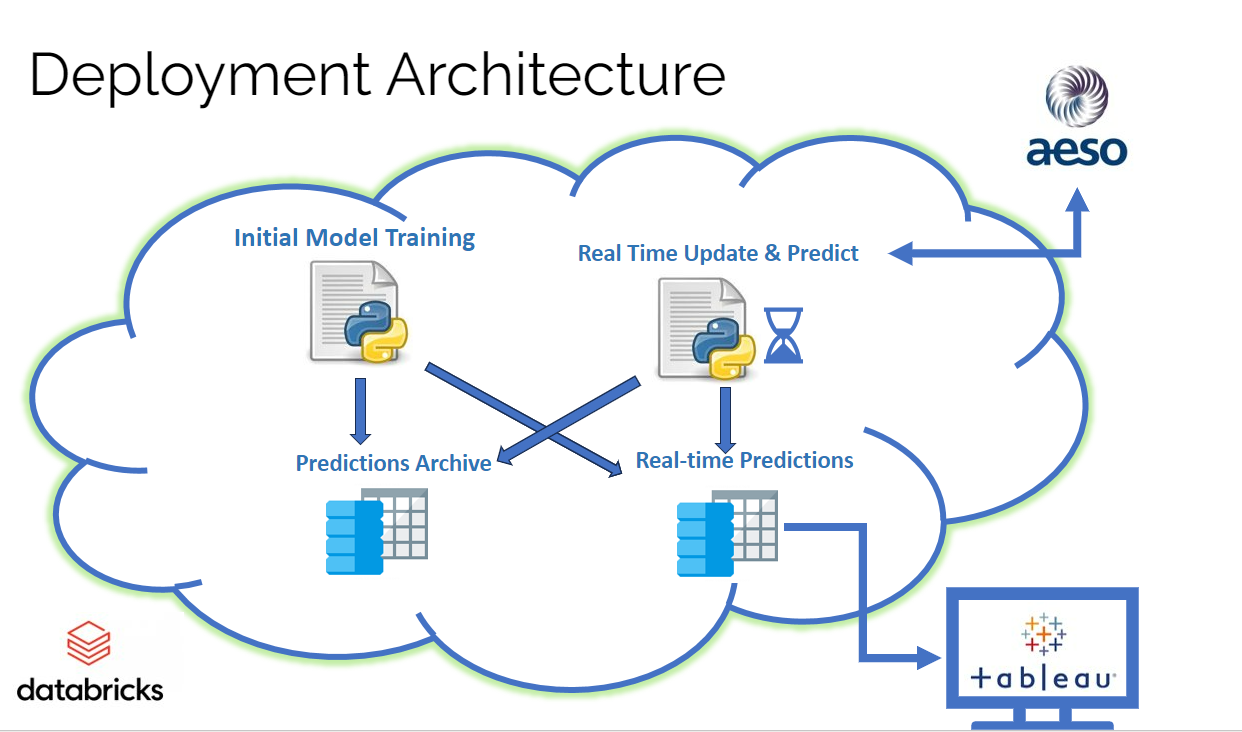

### Data Product and Result 

Our data products offer a scalable and real-time prediction pipeline that accurately forecasts energy prices for the next 12 hours. These predictions come with a high level of explainability, allowing our partners to gain valuable insights and make well-informed decisions regarding their energy purchases. To facilitate this, we have developed a reactive tableau dashboard that empowers users to easily access and visualize the real-time results.

The dashboard is thoughtfully structured into three primary sections to enhance user experience. At the top, the first section features a comprehensive 24-hour energy price timeline chart. This chart provides a holistic view of energy prices by displaying actual prices for the previous 12 hours and forecasted prices for the upcoming 12 hours. Additionally, each hourly prediction is accompanied by a 95% confidence interval, offering a clear representation of the margin of error associated with each forecast. By leveraging this chart, stakeholders can readily assess future price forecasts and gain valuable insights into their projected costs.

Moving to the lower left, the second section presents a dynamic bar chart that offers a deeper understanding of the key factors driving each prediction. The chart highlights the top four features that contribute to each prediction, providing accompanying explanatory text for further clarity. Other contributing features are grouped under the category of "Others" due to their multitude. Notably, this bar chart is designed to be reactive, meaning it dynamically updates as users hover over specific predictions in the first chart. Consequently, the associated features for each selected prediction are displayed, enabling users to gain a comprehensive understanding of how each feature influences the percentage increase or decrease in the prediction from the average value. This feature-level explanation ensures transparency and empowers users to grasp the underlying drivers behind the predictions

Finally, the third section showcases a time series plot illustrating four significant global factors that exhibit a robust correlation with energy prices. These factors include the ratio of total energy produced by gas and wind, as well as the available reserves of gas and wind supply to meet potential demand spikes. By visualizing this time series plot, users can easily monitor and analyze the impact of these crucial factors on energy prices, allowing them to make more informed decisions based on their understanding of the market dynamics.

Our ML pipeline, hosted on Databricks, is scheduled to run every hour, ensuring that the model is continuously retrained with the latest power prices published by AESO. The pipeline generates 12-hour predictions, which are then exported to Databricks' Hive warehouse. Seamlessly integrated with our Tableau dashboard, these predictions are continuously updated to provide real-time accuracy.

 We offer our solution in two formats: one that can be configured within Databricks and another designed for local use, allowing for further development. In the local production version, users initiate the prediction process with a simple command, and the Tableau workbook connects to local CSV files.

Databricks is highly scalable and capable of handling data-intensive processes, making it an ideal computing engine. Conversely, Tableau stands out for its user-friendly maintenance and extensive built-in features, making it an efficient tool for visualizing predictions. Tableau seamlessly integrates with various data sources, enabling easy access and analysis within a unified interface. However, there are certain challenges to consider. Currently, our Databricks cluster computation speed is slower than personal laptops due to a lack of GPU support in the current configuration. Additionally, certain features available in Python's Plotly are either absent or more challenging to implement in Tableau, given its non-code-based approach. The use of the Dash library in combination with Plotly could have provided more advanced and customizable visualizations, which unfortunately we were unable to explore due to time constraints.

![image.png](tableau_dashboard.jpg)

### Conclusion and Recommendations 

The main aim of this project was to address the challenges faced by energy-intensive organizations in Alberta, which heavily depend on accurate electricity price forecasts for business planning and optimization. Our data product serves to mitigate these challenges by providing an interpretable, and more accurate prediction of energy prices, extending the forecast window from 6 to 12 hours. Our product offering a scalable and real-time prediction pipeline integrated with a reactive Tableau dashboard for visualizing real-time market price predictions can enable the energy buyers of Alberta to estimate their future energy costs accurately and can help them potentially prepare for alternative energy sources that can reduce their costs and maximize their profits.

While this project succeeded in meeting its scientific objectives, it is important to acknowledge some limitations that influenced both the process and outcomes:

**Price is complex**

Price is determined when markets clear, i.e. when demand and supply match. Any factor affecting either the supply or demand side can potentially impact the price dynamics. Power prices in a liberalized market like Alberta are also influenced by numerous interconnected factors. While this project's machine learning pipeline accounted for several key variables, accurately predicting power prices requires considering a wide range of factors, including unexpected events and unusual circumstances. For example, factors such as unforeseen failures, interruptions, or disruptions in power generation can significantly impact supply and subsequently affect prices. 

**High volatility means high uncertainty** 

The power price data in Alberta exhibited a lack of clear patterns or trends, making it challenging to develop accurate predictions. Also, both average and variance of the power price has been consistantly increasing in past few years. This upward trend in both the average price and the volatility of prices adds another layer of complexity to the forecasting task. The seasonal influences were intertwined with extreme price volatility, further increasing the uncertainty. As a result, accurately forecasting power prices beyond a short-term window remains difficult. Also, as we extended our forecast window to 12 hours, the inherent uncertainty in predicting power prices became more pronounced.

**Data availability, a real binding constraint**

The availability of reliable and comprehensive data posed significant challenges for our project, particularly due to the requirement of predicting power prices on an hourly basis in real time. Even when we identified valuable features with significant associations to price, obtaining them in an hourly and real-time format proved to be a difficult task. The continuous and up-to-date data required to feed into our model was not readily accessible. As a result, we had to rely on a combination of historical data obtained from Tableau and real-time data obtained through APIs for some specific features. 

**Striking the Balance: the Accuracy-Explainability Tradeoff**

Another intriguing aspect we encountered was the classic tug-of-war between accuracy and interpretability. We all know they often pull in opposite directions. Striking a balance between these two was an ongoing challenge in this project. Simpler models like ARIMA provided better interpretability but lacked the sophistication to handle the complexity of this project's problem. On the other hand, more intricate models offered higher accuracy but were often considered black-box models, which compromised interpretability. We opted for the LightGBM model, which provided a middle ground, but achieving the ideal balance remains an area of exploration. Navigating the accuracy-explainability tradeoff does not have a straightforward recipe, as there are numerous potential models that can still be explored.


In dealing with the data challenges encountered during the project, we developed an Azure function capable of scraping real-time power generation data from hourly online reports after we received the approval from AESO. This solution addresses the issue of data availability, and the function can be added to our pipeline in the future. We also encountered challenges when using the sktime package. Moving forward, it could be advantageous to develop certain components internally, which would allow us to optimize our pipelines and have greater control over them.

When considering our model paradigms, we initially contemplated two approaches: one with known features for the next 12 timesteps and another for unknown features. Given the absence of reliable future data, we opted for the latter model. However, with the availability of future data, we can integrate the first model, potentially forming a more effective ensemble for improved results. We could also continue exploring advanced machine learning models, particularly deep learning models such as transformers, balancing the trade-off between accuracy and interpretability.

Despite the numerous challenges encountered, we were successful in achieving our scientific objectives. We developed a product capable of delivering 12-hour forecasts with a high level of interpretability and a defined margin of error, empowering energy buyers to make well-informed decisions with greater confidence. The journey was arduous, but as the saying goes, "nothing worth having comes easy." Our efforts culminated in a product that is robust, effective, and instrumental in navigating the complexities of the energy market.